In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import glob
import seaborn as sns
from scipy.optimize import minimize
import random

In [26]:
def date_parse(datestr,fmt='%Y-%m-%dT%H:%M:%SZ'):
    return datetime.datetime.strptime(datestr,fmt)

def calculate_var_95(portfolio_returns):
    """
    Calculate the Value at Risk (VaR) at the 95% confidence interval for a given portfolio.

    Parameters:
    portfolio_returns (numpy array): An array of portfolio returns.

    Returns:
    float: The VaR at the 95% confidence level expressed as a percentage.
    """
    # Sort the portfolio returns in ascending order
    sorted_returns = np.sort(portfolio_returns)

    # Determine the number of data points
    N = len(sorted_returns)

    # Calculate the index corresponding to the 5th percentile (95% confidence level)
    percentile_index = int(0.05 * N)

    # Find the return value at the 5th percentile
    var_95 = sorted_returns[percentile_index]

    # Express VaR as a percentage by multiplying it by 100
    var_95_percent = var_95 * 100

    return var_95_percent


In [70]:
# read in data
filelist = glob.glob("../Intraday_StockData/*_intraday.csv")

stock_dict = {}

for filename in filelist:
    ticker = filename.split('/')[-1].split('_')[0]
    if ticker in ['AAPL','NVDA','AMZN','GOOGL']:
        #these had splits in the range, so skipping for now until split accounted for (should be easy)
        print(f'Skipping {ticker}')
        continue
    print(ticker)
    stock_dict[ticker] = pd.read_csv(filename,parse_dates=[0],date_format='%Y-%m-%dT%H:%M:%SZ')
    # convert to Eastern time, not sure if needed
    stock_dict[ticker]['timestamp'] = stock_dict[ticker]['timestamp'] #- datetime.timedelta(hours=4)


Skipping AAPL
Skipping NVDA
WFC
LLY
MSFT
JPM
MRK
ABBV
Skipping GOOGL
MA
UNH
Skipping AMZN
BAC
JNJ
V


In [71]:
trading_days = (stock_dict['ABBV']['timestamp'].iloc[-1] - stock_dict['ABBV']['timestamp'][0]).days * (5/7)
print(trading_days)
risk_free_returns = pd.DataFrame()
print(stock_dict['ABBV']['timestamp'][34:34*2+1])

1305.0
34   2019-03-18 11:00:00
35   2019-03-18 12:00:00
36   2019-03-18 13:15:00
37   2019-03-18 13:30:00
38   2019-03-18 13:45:00
39   2019-03-18 14:00:00
40   2019-03-18 14:15:00
41   2019-03-18 14:30:00
42   2019-03-18 14:45:00
43   2019-03-18 15:00:00
44   2019-03-18 15:15:00
45   2019-03-18 15:30:00
46   2019-03-18 15:45:00
47   2019-03-18 16:00:00
48   2019-03-18 16:15:00
49   2019-03-18 16:30:00
50   2019-03-18 16:45:00
51   2019-03-18 17:00:00
52   2019-03-18 17:15:00
53   2019-03-18 17:30:00
54   2019-03-18 17:45:00
55   2019-03-18 18:00:00
56   2019-03-18 18:15:00
57   2019-03-18 18:30:00
58   2019-03-18 18:45:00
59   2019-03-18 19:00:00
60   2019-03-18 19:15:00
61   2019-03-18 19:30:00
62   2019-03-18 19:45:00
63   2019-03-18 20:00:00
64   2019-03-18 20:15:00
65   2019-03-18 20:30:00
66   2019-03-18 21:30:00
67   2019-03-18 21:45:00
68   2019-03-18 22:00:00
Name: timestamp, dtype: datetime64[ns]


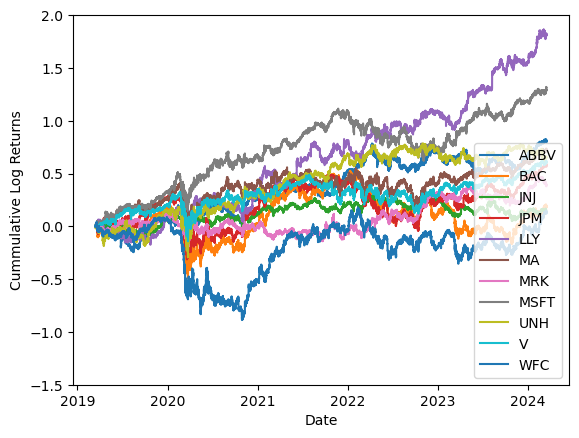

In [118]:
fig,ax = plt.subplots()
for ticker in sorted(stock_dict.keys()):
    ax.plot(stock_dict[ticker]['timestamp'],
            np.log(stock_dict[ticker]['close'] / stock_dict[ticker]['close'][0]),
            #np.cumsum((stock_dict[ticker]['close'][1:].values - stock_dict[ticker]['close'][:-1].values)/stock_dict[ticker]['close'][1:].values),
            label=ticker)

ax.set_ylim(-1.5,2)
ax.set_ylabel('Cummulative Log Returns')
ax.set_xlabel('Date')
ax.legend()

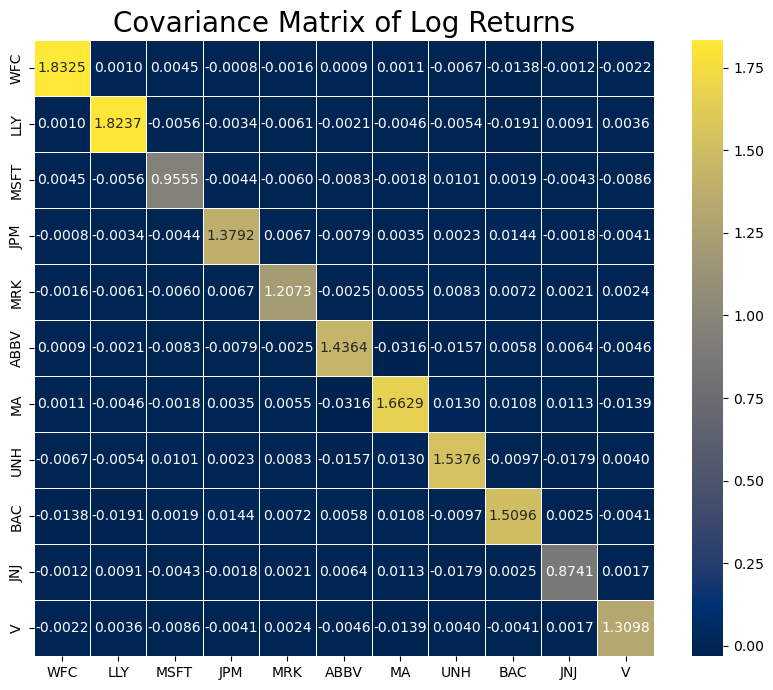

In [89]:
# let's look at covariance matrix
log_returns = pd.DataFrame()

for ticker in stock_dict.keys():
    log_returns[ticker] = np.log(stock_dict[ticker]['close'] / stock_dict[ticker]['close'].shift(1))

log_returns = log_returns.dropna()
returns = (np.exp(log_returns)-1)

# Calculate the covariance matrix
covariance_matrix = trading_days*((returns).cov())
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(100*covariance_matrix, annot=True, cmap='cividis', fmt='.4f', linewidths=.5)
plt.title('Covariance Matrix of Log Returns', fontsize=20)
plt.show()

In [119]:
#Find Sharpe Ratios and Value at risk at 95% cofidence interval of the stocks in stock_symbols over the historical period

# Risk free rate of 5% annual
risk_free_rate = 0.05   

# Initialize a dictionary to store Sharpe ratios
sharpe_ratios = {}


# Initialize a dictionary to store value at risk at 95% cofidence interval
var_95 = {}

# Calculate and print the Sharpe ratio for each individual stock
for stock_symbol in stock_dict.keys():
    excess_returns = (returns[stock_symbol] - (risk_free_rate/252/34)) #Divide 252 to adjust for daily interest, also a factor of 34? for 15 minute cadence
    #print(excess_returns)
    mean_excess_return = excess_returns.mean()*trading_days
    #print(mean_excess_return)
    std_dev_excess_return = excess_returns.std()*np.sqrt(trading_days)
    sharpe_ratio = mean_excess_return / std_dev_excess_return
    sharpe_ratios[stock_symbol] = sharpe_ratio
    
for stock_symbol in stock_dict.keys():
    value_at_risk = calculate_var_95(returns[stock_symbol])
    var_95[stock_symbol] = value_at_risk
    

# Print Sharpe ratios for each stock
for stock_symbol in stock_dict.keys():
    print(f"{stock_symbol}: Sharpe Ratio = {sharpe_ratios[stock_symbol]:.4f}")
    print(f"{stock_symbol}: Volatility = {np.sqrt(covariance_matrix[stock_symbol][stock_symbol])}")
    print(f"{stock_symbol}: Value at Risk = {var_95[stock_symbol]}")
    print('---------')


WFC: Sharpe Ratio = -0.0228
WFC: Volatility = 0.13537111218521283
WFC: Value at Risk = -0.49482681061627787
---------
LLY: Sharpe Ratio = 0.4260
LLY: Volatility = 0.1350428137418155
LLY: Value at Risk = -0.46810591769719245
---------
MSFT: Sharpe Ratio = 0.2689
MSFT: Volatility = 0.09775049254244836
MSFT: Value at Risk = -0.3412049923677829
---------
JPM: Sharpe Ratio = -0.0040
JPM: Volatility = 0.11744098690498406
JPM: Value at Risk = -0.4215938303341882
---------
MRK: Sharpe Ratio = 0.0762
MRK: Volatility = 0.10987648079555772
MRK: Value at Risk = -0.4023580050528719
---------
ABBV: Sharpe Ratio = 0.1600
ABBV: Volatility = 0.11984817336347493
ABBV: Value at Risk = -0.432357917162729
---------
MA: Sharpe Ratio = 0.1508
MA: Volatility = 0.12895267595435206
MA: Value at Risk = -0.47350500106406734
---------
UNH: Sharpe Ratio = 0.1622
UNH: Volatility = 0.12399966781406854
UNH: Value at Risk = -0.44757680701540403
---------
BAC: Sharpe Ratio = 0.0517
BAC: Volatility = 0.1228656342607971
B

In [91]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 3% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_dict.keys()}


# Number of assets
n_assets = len(stock_dict.keys())

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
              {'type': 'ineq', 'fun': lambda weights: min(weights)-.03},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, method='SLSQP', constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for stock, weight in zip(stock_dict.keys(), optimal_weights):
    print(f"{stock}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
WFC: Weight = 0.0668
LLY: Weight = 0.0676
MSFT: Weight = 0.1292
JPM: Weight = 0.0874
MRK: Weight = 0.0994
ABBV: Weight = 0.0872
MA: Weight = 0.0725
UNH: Weight = 0.0793
BAC: Weight = 0.0793
JNJ: Weight = 0.1370
V: Weight = 0.0941


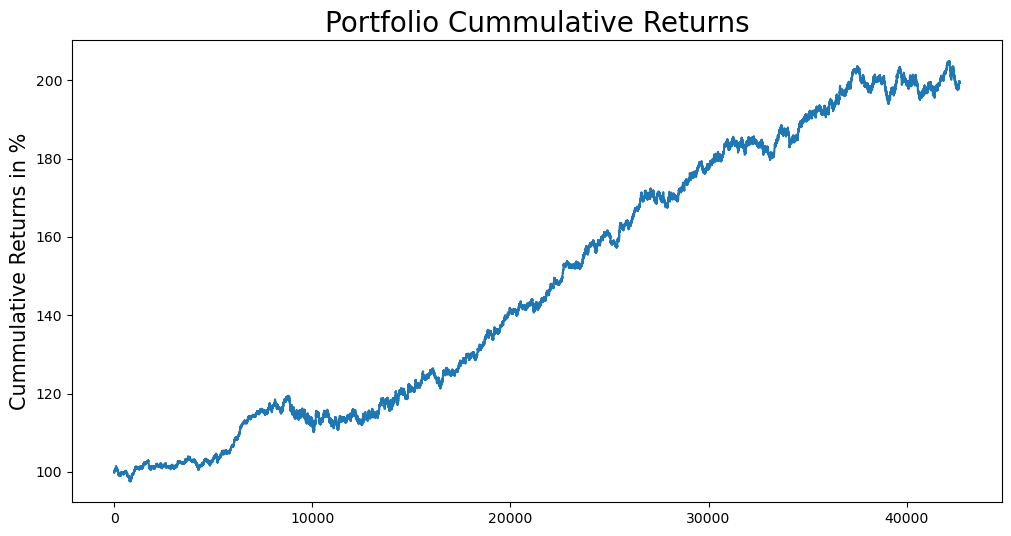

In [117]:
#Create a Portfolio using the optimal weights found to minimimize volatility subject to the investment constraints
#Create a visual of the portfolio's cumulative profits over the historical period


# Create a list to store individual asset returns
asset_returns_array = np.array([returns[stock] for stock in stock_dict.keys()])


# Transpose the optimal_weights to match dimensions
optimal_weights_transposed = optimal_weights[:, np.newaxis]

# Calculate the portfolio returns by taking a weighted sum of asset returns
portfolio_returns = np.sum(asset_returns_array * optimal_weights_transposed, axis=0)


#Create visual of portfolio cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12,6))

plt.plot(returns.index, cumulative_returns*100)
plt.title('Portfolio Cummulative Returns', size=20)
plt.ylabel('Cummulative Returns in %', fontsize = 15)

plt.show()

In [87]:
# now let's work in the sentiment anaylsis
sentiment_dict = pd.read_csv('../data/master_articles.csv',parse_dates=[0,11,12,13],date_format='%Y-%m-%d %H:%M:%S+00:00')
sentiment_dict


,Publishing Time,Ticker,Sector,Source,Headline,Text,URL,finvader_tot,finvader_neg,finvader_neu,finvader_pos,Next Open Time,Next Closing Time,Next Market Date
0,2019-03-15 10:46:42,WFC,Finance,The Motley Fool,Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...,We learned this week that the scandal-plagued ...,https://www.fool.com/investing/2019/03/14/did-...,0.2869,0.000,0.823,0.177,2019-03-15 13:30:00,2019-03-15 20:00:00,2019-03-18 04:00:00
1,2019-03-15 10:47:26,AAPL,Technology,The Motley Fool,Don't Underestimate Apple's iPhone Business,The segment is an invaluable asset to Apple's ...,https://www.fool.com/investing/2019/03/14/dont...,0.0396,0.000,0.660,0.340,2019-03-15 13:30:00,2019-03-15 20:00:00,2019-03-18 04:00:00
2,2019-03-15 11:33:00,MA,Finance,Forbes,A Closer Look At Mastercard's Key Value Drivers,Mastercard has consistently beat street estima...,https://www.forbes.com/sites/greatspeculations...,0.8922,0.042,0.595,0.363,2019-03-15 13:30:00,2019-03-15 20:00:00,2019-03-18 04:00:00
3,2019-03-15 11:52:45,BAC,Finance,Benzinga,Jim Cramer Gives His Opinion On Bank Of Americ...,"On CNBC's ""Mad Money Lightning Round"", Jim Cra...",https://feeds.benzinga.com/~r/benzinga/~3/Fwtd...,0.0129,0.034,0.899,0.067,2019-03-15 13:30:00,2019-03-15 20:00:00,2019-03-18 04:00:00
4,2019-03-15 13:29:39,GOOGL,Technology,Benzinga,Uber And Waymo Seeking Outside Funding For Aut...,Commercially viable autonomous vehicle (AV) te...,https://feeds.benzinga.com/~r/benzinga/~3/fizU...,-0.3215,0.076,0.734,0.189,2019-03-15 13:30:00,2019-03-15 20:00:00,2019-03-18 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63698,2024-03-15 20:23:00,MRK,Healthcare,PRNewsWire,FarmSee Ltd Announces the Completion of a Mino...,Cutting edge & AI solution for continuous and ...,https://www.prnewswire.com/news-releases/farms...,0.8458,0.042,0.696,0.262,2024-03-18 13:30:00,2024-03-18 20:00:00,2024-03-18 04:00:00
63699,2024-03-15 21:00:00,NVDA,Technology,The Motley Fool,"Here's My Top ""Magnificent Seven"" Stock to Buy...",Nvidia believes the long-term data center oppo...,https://www.fool.com/investing/2024/03/15/top-...,0.8700,0.019,0.674,0.307,2024-03-18 13:30:00,2024-03-18 20:00:00,2024-03-18 04:00:00
63700,2024-03-15 21:03:01,AAPL,Technology,Business Insider,Tim Cook's comments about iPhone sales in Chin...,Apple has agreed to pay $490 million to settle...,https://www.businessinsider.com/tim-cooks-comm...,0.2789,0.047,0.813,0.140,2024-03-18 13:30:00,2024-03-18 20:00:00,2024-03-18 04:00:00
63701,2024-03-15 22:18:35,AAPL,Technology,The Guardian,Apple to pay $490m to settle claims it misled ...,Company denied that Tim Cook deceived investor...,https://www.theguardian.com/technology/2024/ma...,-0.6772,0.211,0.618,0.171,2024-03-18 13:30:00,2024-03-18 20:00:00,2024-03-18 04:00:00


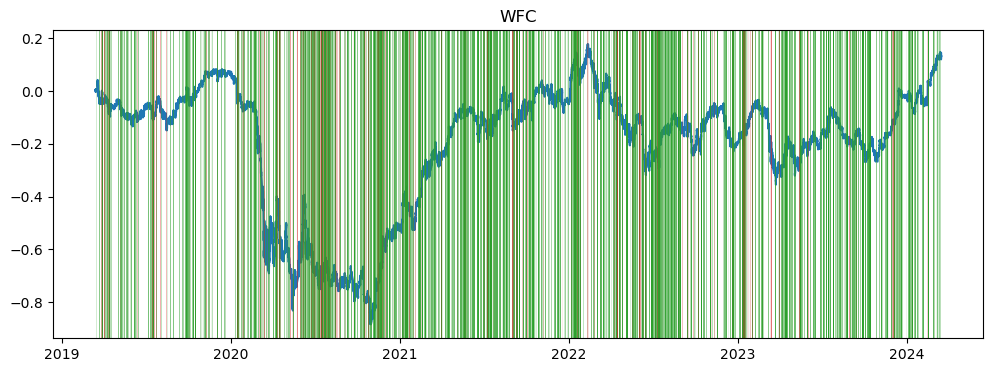

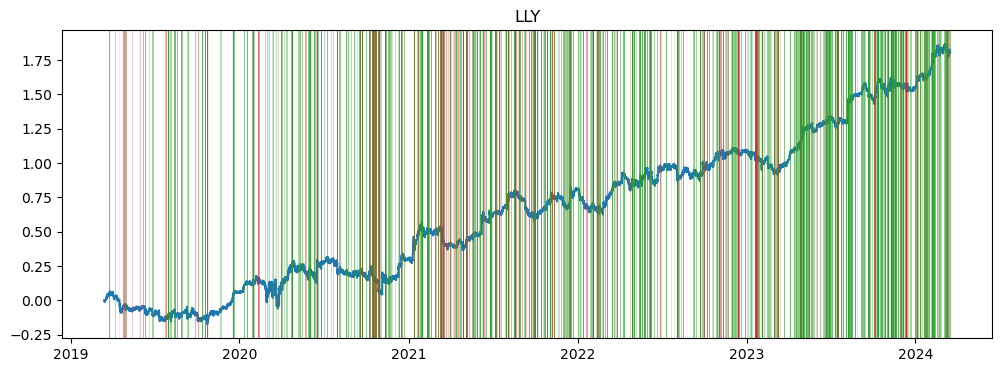

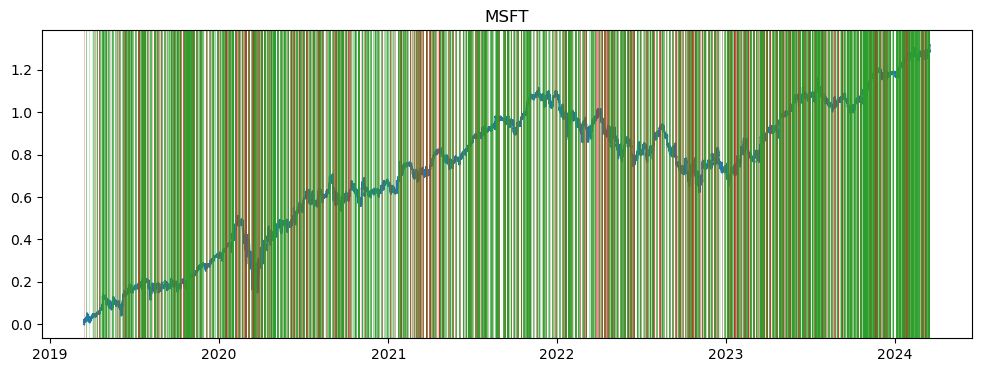

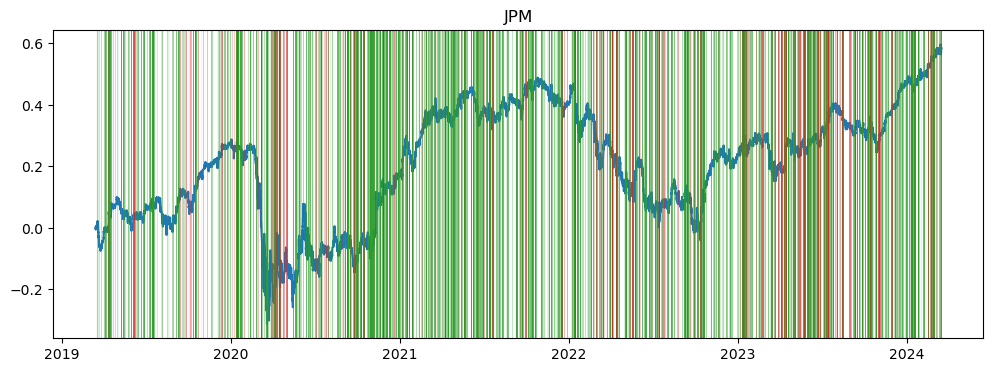

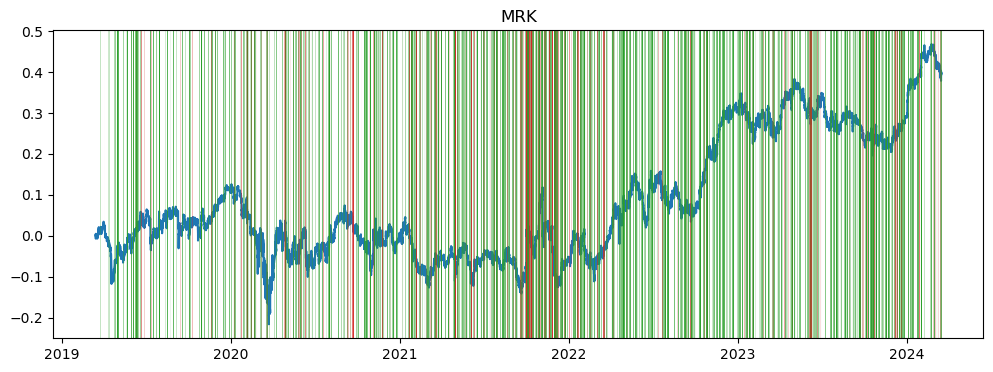

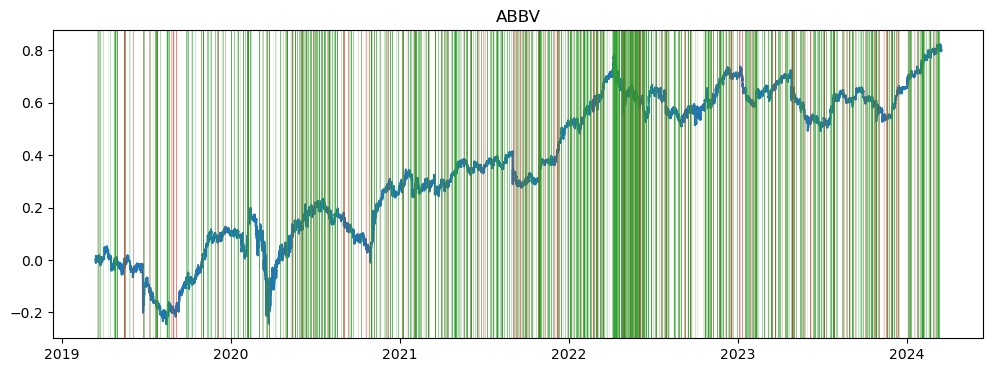

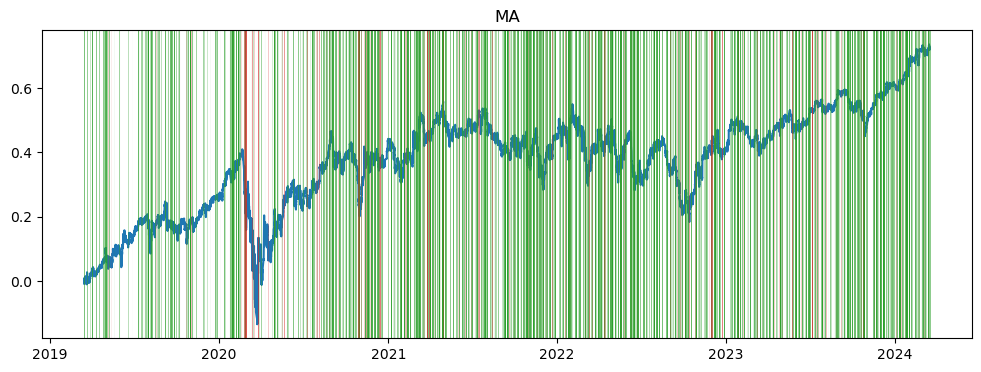

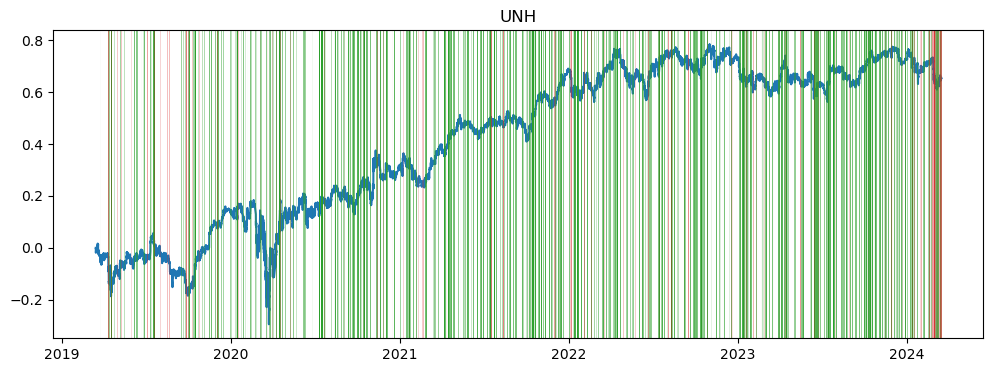

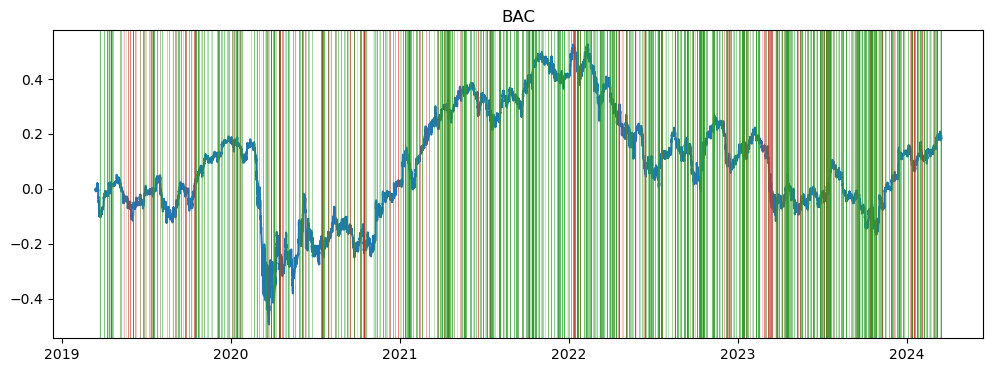

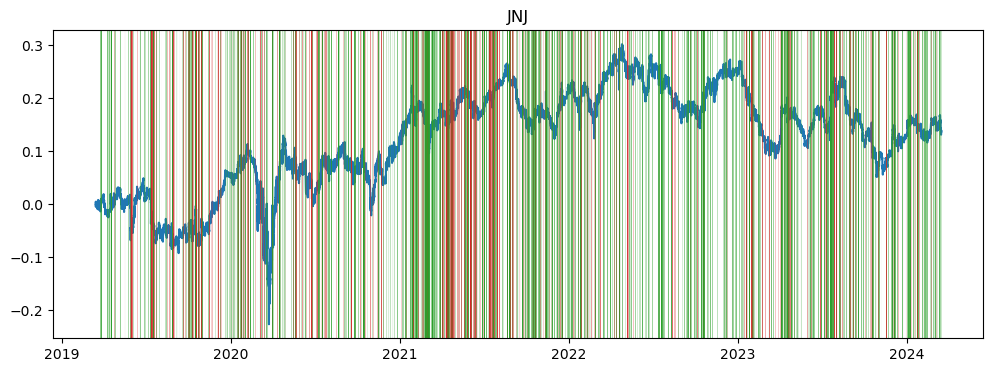

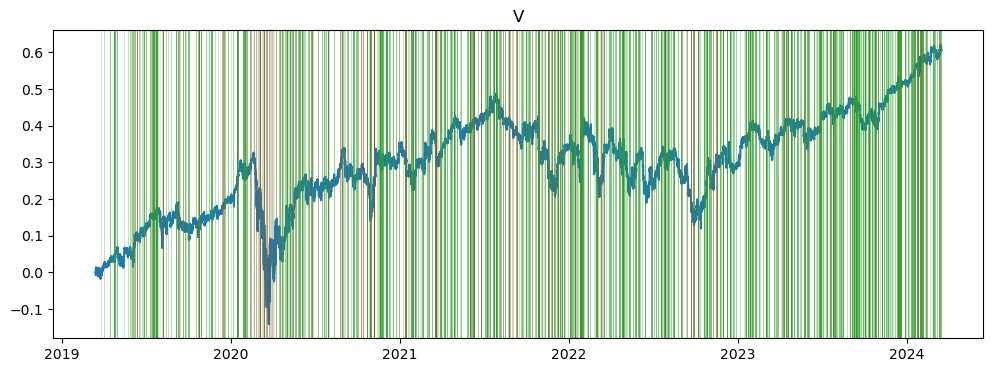

In [107]:

for ticker in stock_dict.keys():
    sent_dict = sentiment_dict[sentiment_dict['Ticker']==ticker]
    fig,ax = plt.subplots(figsize=(12,4))
    ax.plot(stock_dict[ticker]['timestamp'],np.log(stock_dict[ticker]['close'] / stock_dict[ticker]['close'][0]))
    for index, row in sent_dict.iterrows():
        if row['finvader_tot'] < 0:
            ax.axvline(row['Publishing Time'],color='C3',linewidth=0.5,alpha=np.abs(row['finvader_tot']))
        if row['finvader_tot'] > 0:
            ax.axvline(row['Publishing Time'],color='C2',linewidth=0.5,alpha=row['finvader_tot'])
    ax.set_title(f'{ticker}')

    plt.show()

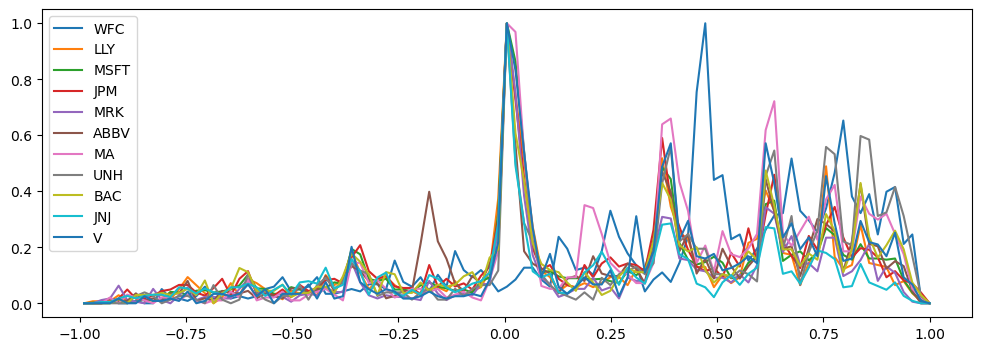

In [116]:
fig,ax = plt.subplots(figsize=(12,4))
for ticker in stock_dict.keys():
    sent_dict = sentiment_dict[sentiment_dict['Ticker']==ticker]
    bins = np.linspace(-1,1.01,100)
    hist, bins = np.histogram(sent_dict['finvader_tot'],bins)
    bin_centers = (bins[1:] + bins[:-1])/2

    ax.plot(bin_centers,hist/hist.max(),label=ticker)

ax.legend()

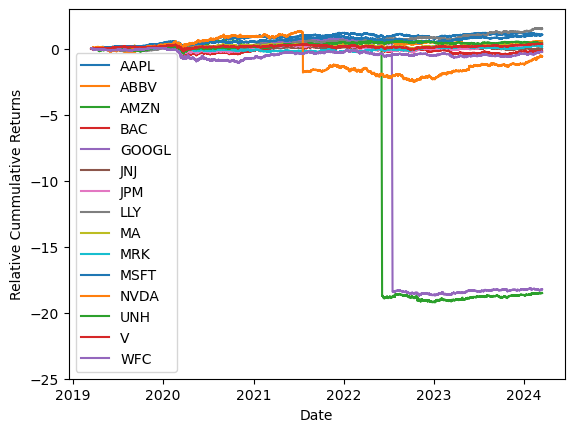

In [104]:
fig,ax = plt.subplots()
for ticker in sorted(stock_dict.keys()):
    ax.plot(stock_dict[ticker]['timestamp'][1:],
            np.cumsum((stock_dict[ticker]['close'][1:].values - stock_dict[ticker]['close'][:-1].values)/stock_dict[ticker]['close'][1:].values),
            label=ticker)

ax.set_ylim(-25,3)
ax.set_ylabel('Relative Cummulative Returns')
ax.set_xlabel('Date')
ax.legend()

In [ ]:
# account prices for stock split on 2020-08-28
data = stock_dict['NVDA']
split_inds = data['timestamp'] < datetime.datetime(year=2021,month=6,day=3,hour=00)